In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkConf
import pyspark.sql.functions as f
import os, sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [8]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml import Pipeline

In [2]:
conf = SparkConf()
conf.set("spark.app.name","clustering")
conf.set("spark.master","local[*]")
conf.set("spark.driver.memory","8g")

In [3]:
spark = SparkSession.builder\
                    .config(conf=conf)\
                    .getOrCreate()

**A First Take On Clustering**

In [4]:
data_without_header = spark.read\
                            .format("csv")\
                            .option("header",False)\
                            .option("inferSchema",True)\
                            .load(r"C:\Users\blais\Documents\ML\data\kddcup\kddcup.data.corrected")

In [5]:
column_names =  [  "duration", "protocol_type", "service", "flag",
                "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent",
                "hot", "num_failed_logins", "logged_in", "num_compromised",
                "root_shell", "su_attempted", "num_root", "num_file_creations",
                "num_shells", "num_access_files", "num_outbound_cmds",
                "is_host_login", "is_guest_login", "count", "srv_count",
                "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
                "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
                "dst_host_count", "dst_host_srv_count",
                "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
                "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
                "dst_host_serror_rate", "dst_host_srv_serror_rate",
                "dst_host_rerror_rate", "dst_host_srv_rerror_rate",
                "label"]

In [6]:
data = data_without_header.toDF(*column_names)

A bit of exploration:
- What labels are present in the data and how many are there of each. 

In [7]:
data.groupBy("label").agg(f.count("*").alias('count')).sort(f.col('count'),ascending=False).show(25)

+----------------+-------+
|           label|  count|
+----------------+-------+
|          smurf.|2807886|
|        neptune.|1072017|
|         normal.| 972781|
|          satan.|  15892|
|        ipsweep.|  12481|
|      portsweep.|  10413|
|           nmap.|   2316|
|           back.|   2203|
|    warezclient.|   1020|
|       teardrop.|    979|
|            pod.|    264|
|   guess_passwd.|     53|
|buffer_overflow.|     30|
|           land.|     21|
|    warezmaster.|     20|
|           imap.|     12|
|        rootkit.|     10|
|     loadmodule.|      9|
|      ftp_write.|      8|
|       multihop.|      7|
|            phf.|      4|
|           perl.|      3|
|            spy.|      2|
+----------------+-------+



Data has got some nonnumeric feaures - for example - second column may be tcp, udp, or icmp, but k-means clustering requires numeric features. The final label column is also nonnumeric. To begin, these will simply be ignored. 
- Then follow the Spark ML pattern => A vector assembler creates a feature vector, a kmeans implementation creates a model from the feature vectors, and a pipeline stitches it all together. From the resulting model, its then possible to extract and examine cluster centers.

In [9]:
numeric_only = data.drop("protocol_type","service","flag").cache()

In [11]:
assembler = VectorAssembler().setInputCols(numeric_only.columns[:-1])\
                             .setOutputCol("featureVector")

In [12]:
kmeans = KMeans().setPredictionCol('cluster').setFeaturesCol("featureVector")

In [13]:
pipeline = Pipeline().setStages([assembler, kmeans])

In [14]:
pipeline_model = pipeline.fit(numeric_only)

In [15]:
kmeans_model = pipeline_model.stages[1]

In [16]:
from pprint import pprint

In [17]:
pprint(kmeans_model.clusterCenters())

[array([4.83401949e+01, 1.83462155e+03, 8.26203190e+02, 5.71611720e-06,
       6.48779303e-04, 7.96173468e-06, 1.24376586e-02, 3.20510858e-05,
       1.43529049e-01, 8.08830584e-03, 6.81851124e-05, 3.67464677e-05,
       1.29349608e-02, 1.18874823e-03, 7.43095237e-05, 1.02114351e-03,
       0.00000000e+00, 4.08294086e-07, 8.35165553e-04, 3.34973508e+02,
       2.95267146e+02, 1.77970317e-01, 1.78036989e-01, 5.76648988e-02,
       5.77299094e-02, 7.89884132e-01, 2.11796106e-02, 2.82608101e-02,
       2.32981078e+02, 1.89214283e+02, 7.53713390e-01, 3.07109788e-02,
       6.05051931e-01, 6.46410789e-03, 1.78091184e-01, 1.77885898e-01,
       5.79276115e-02, 5.76592214e-02]),
 array([1.0999000e+04, 0.0000000e+00, 1.3099374e+09, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00

Inertia:

In [18]:
kmeans_model.summary.trainingCost

4.663458567026119e+18

This is a good opportunity to use the given labels to get an intuitive sense of what went into these clusters by counting the labels within each cluster.

In [19]:
with_cluster = pipeline_model.transform(numeric_only)

In [21]:
with_cluster.select("cluster","label").groupBy("cluster","label").count()\
                                      .orderBy(f.col("cluster"), f.col("count").desc()).show(30)

+-------+----------------+-------+
|cluster|           label|  count|
+-------+----------------+-------+
|      0|          smurf.|2807886|
|      0|        neptune.|1072017|
|      0|         normal.| 972781|
|      0|          satan.|  15892|
|      0|        ipsweep.|  12481|
|      0|      portsweep.|  10412|
|      0|           nmap.|   2316|
|      0|           back.|   2203|
|      0|    warezclient.|   1020|
|      0|       teardrop.|    979|
|      0|            pod.|    264|
|      0|   guess_passwd.|     53|
|      0|buffer_overflow.|     30|
|      0|           land.|     21|
|      0|    warezmaster.|     20|
|      0|           imap.|     12|
|      0|        rootkit.|     10|
|      0|     loadmodule.|      9|
|      0|      ftp_write.|      8|
|      0|       multihop.|      7|
|      0|            phf.|      4|
|      0|           perl.|      3|
|      0|            spy.|      2|
|      1|      portsweep.|      1|
+-------+----------------+-------+



Clustering wasn't so helpful in this situation as only one point ended up in cluster 1

**Choosing K:**

A clustering could be considered good if each data point were near its closest centroid, where 'near' is defined by the Euclidean distance. 

In [22]:
from pyspark.sql import DataFrame
from pyspark.ml.evaluation import ClusteringEvaluator

In [23]:
from random import randint

In [30]:
def clustering_score(input_data, k):
    assembler = VectorAssembler().setInputCols(input_data.columns[:-1])\
                                 .setOutputCol("featureVector")
    kmeans = KMeans().setSeed(randint(100,100000))\
                     .setK(k)\
                     .setPredictionCol("cluster")\
                     .setFeaturesCol("featureVector")
    pipeline = Pipeline().setStages([assembler,kmeans])
    pipeline_model = pipeline.fit(input_data)
    evaluator = ClusteringEvaluator(predictionCol='cluster',featuresCol='featureVector')
    predictions = pipeline_model.transform(input_data)
    score = evaluator.evaluate(predictions)
    return score

In [31]:
for k in list(range(20,100,20)):
    print(clustering_score(numeric_only,k))

0.9999452090708707
0.9997511000860653
0.9802290654054082
0.9990730981698706


Even with intelligent optimisation algorithms,  kmeans still has some element of randomness associated with it and cannot guarantee optimal clustering. 
We can improve by running the algorithm longer. setting the tolerance or maxIter values

what we've done:
- increased the default MaxIter from 20 to 40
- decreased the tolerance from 1.0e-4 to 1.0e-5

In [32]:
def clustering_score(input_data, k):
    assembler = VectorAssembler().setInputCols(input_data.columns[:-1])\
                                 .setOutputCol("featureVector")
    kmeans = KMeans().setSeed(randint(100,100000))\
                     .setK(k)\
                     .setPredictionCol("cluster")\
                     .setFeaturesCol("featureVector")\
                     .setMaxIter(40)\
                     .setTol(1.0e-5)
    pipeline = Pipeline().setStages([assembler,kmeans])
    pipeline_model = pipeline.fit(input_data)
    evaluator = ClusteringEvaluator(predictionCol='cluster',featuresCol='featureVector')
    predictions = pipeline_model.transform(input_data)
    score = evaluator.evaluate(predictions)
    return score

In [33]:
for k in list(range(20,100,20)):
    print(clustering_score(numeric_only,k))

0.9999469203760745
0.9991258366358806
0.9749100444885669
0.9831635132137191


Perfect - training just a little bit longer has restored normalcy. Optimal k seems to be 20, and silhouette score decreases as k increases - considerably from k=40 onwards. 

Looks like 20 clusters is a good number - predict then plot and visualize:

In [34]:
##### 20 clusters
assembler_20 = VectorAssembler().setInputCols(numeric_only.columns[:-1])\
                               .setOutputCol("featureVector")
kmeans_20 = KMeans().setSeed(42).setK(20).setPredictionCol("cluster").setFeaturesCol("featureVector").setMaxIter(40).setTol(1.0e-5)
pipeline_20 = Pipeline().setStages([assembler_20,kmeans_20])
pipeline_20_model = pipeline_20.fit(numeric_only)

In [35]:
# predict and evaluate
evaluator = ClusteringEvaluator(predictionCol="cluster",featuresCol="featureVector")

In [36]:
predictions_20 = pipeline_20_model.transform(numeric_only)

In [37]:
evaluator.evaluate(predictions_20)

0.9999448648169129

In [39]:
predictions_20.select("cluster").distinct().show(25)

+-------+
|cluster|
+-------+
|      0|
|      1|
|      9|
|     10|
|     11|
|     12|
|      3|
|      4|
|      2|
|     13|
|     16|
|     15|
|     14|
|      6|
|      5|
|     17|
|      8|
|      7|
+-------+



In [41]:
predictions_20.count()

4898431

In [45]:
0.01*4898431

48984.31

Take a sample (stratified) from the data and visualize:

In [63]:
clusters_list = list(map(lambda x: x.cluster, predictions_20.select('cluster').distinct().collect()))

In [64]:
clusters_list

[0, 1, 9, 10, 11, 12, 3, 4, 2, 13, 16, 15, 14, 6, 5, 17, 8, 7]

In [75]:
predictions_20.groupBy("cluster").count().show()

+-------+-------+
|cluster|  count|
+-------+-------+
|      0|4898345|
|      1|      1|
|      9|      3|
|     10|      1|
|     11|     67|
|     12|      2|
|      3|      1|
|      4|      1|
|      2|      1|
|     13|      1|
|     16|      1|
|     15|      1|
|     14|      1|
|      6|      1|
|      5|      1|
|     17|      1|
|      8|      1|
|      7|      1|
+-------+-------+



In [65]:
predictions_20_sample = predictions_20.sampleBy("cluster",{cluster:0.01 for cluster in clusters_list},seed=42)

In [66]:
from pyspark.ml.feature import PCA

In [67]:
pca = PCA(k=3, inputCol="featureVector",outputCol="pca_features")

In [68]:
pca_model = pca.fit(predictions_20_sample)

In [69]:
data_pca = pca_model.transform(predictions_20_sample)

In [70]:
pca_model.explainedVariance.toArray()

array([0.85212335, 0.14519695, 0.00218222])

In [71]:
data_pca.select("pca_features").show(5)

+--------------------+
|        pca_features|
+--------------------+
|[243.714869629250...|
|[217.906966911162...|
|[324.886319789426...|
|[239.342959531343...|
|[268.223078929109...|
+--------------------+
only showing top 5 rows



In [72]:
import matplotlib.pyplot as plt
import numpy as np

In [73]:
data_pca.select('cluster').distinct().show()

+-------+
|cluster|
+-------+
|      0|
+-------+



Explained Variance Ratios: [0.85212335 0.14519695 0.00218222]
Cumulative Variance: 0.9995025171525757


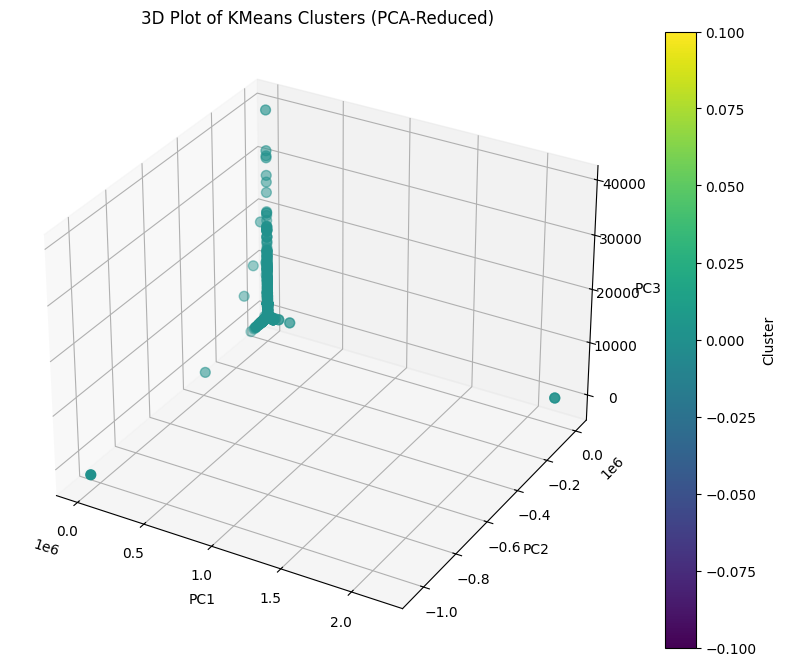

In [74]:
# Collect data for visualization
pandas_df = data_pca.select("pca_features", "cluster").toPandas()

# Extract 3D coordinates
pandas_df["pc1"] = pandas_df["pca_features"].apply(lambda x: x[0])
pandas_df["pc2"] = pandas_df["pca_features"].apply(lambda x: x[1])
pandas_df["pc3"] = pandas_df["pca_features"].apply(lambda x: x[2])

# Check explained variance
explained_variance = pca_model.explainedVariance.toArray()
print(f"Explained Variance Ratios: {explained_variance}")
print(f"Cumulative Variance: {np.sum(explained_variance)}")

# 3D Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(
    pandas_df["pc1"],
    pandas_df["pc2"],
    pandas_df["pc3"],
    c=pandas_df["cluster"],
    cmap="viridis",
    s=50
)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.colorbar(scatter, label="Cluster")
plt.title("3D Plot of KMeans Clusters (PCA-Reduced)")
plt.show()

In [78]:
import plotly.express as px
fig = px.scatter_3d(
    pandas_df,
    x="pc1",
    y="pc2",
    z="pc3",
    color="cluster",
    title="3D Plot of KMeans Clusters (PCA-Reduced)"
)
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

The visualisation shows the data points in 3-D space. The dominant feature of the visualisation is its L shape.  The points seems to vary along this dimension more. Makes sense since the dataset has 2 featues that are on a much larger scale than the others. Whereas most features have values between 0 and 1. The Euclidean distance between points is therefore almost completely determined by these dominant features. Its as though the others don't exist. Important to normalize. 

**Feature Normalization:**
- We can normalise each feature by converting it to a standard score. 

In [79]:
from pyspark.ml.feature import StandardScaler

In [83]:
def clustering_score_2(input_data, k):
    assembler = VectorAssembler().setInputCols(input_data.columns[:-1])\
                                 .setOutputCol("featureVector")
    scaler = StandardScaler().setInputCol("featureVector").setOutputCol("scaledFeatureVector").setWithStd(True).setWithMean(False)
    kmeans = KMeans().setSeed(randint(100,100000)).setK(k).setMaxIter(40).setTol(1.0e-5).setPredictionCol("cluster")\
                     .setFeaturesCol("scaledFeatureVector")
    pipeline = Pipeline().setStages([assembler, scaler, kmeans])
    pipeline_model = pipeline.fit(input_data)

    evaluator = ClusteringEvaluator(predictionCol="cluster",featuresCol="scaledFeatureVector")
    predictions = pipeline_model.transform(input_data)
    score = evaluator.evaluate(predictions)
    return score

In [84]:
for k in list(range(10,120,10)):
    print(k, clustering_score_2(numeric_only, k))

10 0.7194783730873294
20 0.7220314650097778
30 0.8424865337668387
40 0.8882536009634516
50 0.8388281119078036
60 0.8444633639917292
70 0.8654217641738927
80 0.8355440476440775
90 0.8474312288804658
100 0.8079450573174255
110 0.7918606135070357


40 seems like a good spot: good silhouette score.

- Retrain - considering a k of 40
- Sample 1%
- Compute PCA 
- Plot 3D

In [87]:
assembler_40 = VectorAssembler().setInputCols(numeric_only.columns[:-1])\
                                 .setOutputCol("featureVector")
scaler_40 = StandardScaler().setInputCol("featureVector").setOutputCol("scaledFeatureVector").setWithStd(True).setWithMean(False)
kmeans_40 = KMeans().setSeed(randint(100,100000)).setK(40).setMaxIter(40).setTol(1.0e-5).setPredictionCol("cluster")\
                     .setFeaturesCol("scaledFeatureVector")
pipeline_40 = Pipeline().setStages([assembler_40, scaler_40, kmeans_40])
pipeline_model_40 = pipeline_40.fit(numeric_only)

In [88]:
predictions_40 = pipeline_model_40.transform(numeric_only)

In [90]:
predictions_40.groupBy("cluster").count().show()

+-------+------+
|cluster| count|
+-------+------+
|     31|    42|
|     34|  3852|
|     28|   813|
|     27|  7596|
|     22|  1810|
|      1| 69747|
|     13|  2158|
|      6| 70122|
|     16|  4570|
|     20|    92|
|      5|393371|
|     19|   970|
|     15| 11089|
|     37|    16|
|      9| 52042|
|      4| 39399|
|     39|  8464|
|     23|    46|
|      7|    24|
|     10|865059|
+-------+------+
only showing top 20 rows



In [91]:
unique_clusters = list(map(lambda x:x.cluster, predictions_40.select("cluster").distinct().collect()))

In [92]:
predictions_40_sample = predictions_40.sampleBy("cluster",{cluster:0.01 for cluster in unique_clusters},seed=42)

In [93]:
predictions_40_sample.select("cluster").distinct().show()

+-------+
|cluster|
+-------+
|     34|
|     28|
|     27|
|      1|
|     13|
|      6|
|     16|
|      5|
|      9|
|      4|
|     24|
|     29|
|     33|
|     11|
|     30|
|      0|
|     36|
|     15|
|     23|
|     39|
+-------+
only showing top 20 rows



In [94]:
pca = PCA(k=3,inputCol="scaledFeatureVector",outputCol="pcaFeatures")
pca_model = pca.fit(predictions_40_sample)

In [95]:
predictions_pcad = pca_model.transform(predictions_40_sample)

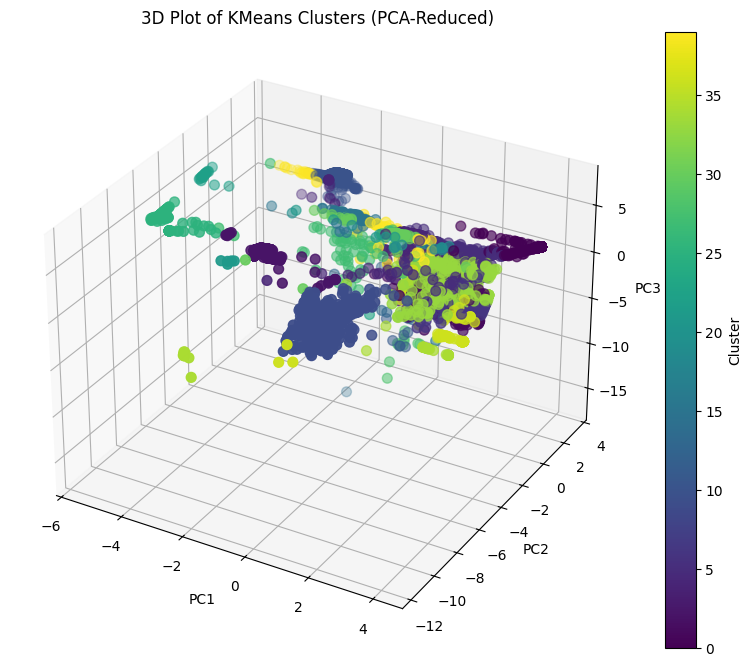

In [99]:
# Collect for plotting
pandas_df = predictions_pcad .select("pcaFeatures", "cluster").toPandas()
pandas_df["pc1"] = pandas_df["pcaFeatures"].apply(lambda x: x[0])
pandas_df["pc2"] = pandas_df["pcaFeatures"].apply(lambda x: x[1])
pandas_df["pc3"] = pandas_df["pcaFeatures"].apply(lambda x: x[2])

# 3D Plot with Plotly
# 3D Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(
    pandas_df["pc1"],
    pandas_df["pc2"],
    pandas_df["pc3"],
    c=pandas_df["cluster"],
    cmap="viridis",
    s=50
)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.colorbar(scatter, label="Cluster")
plt.title("3D Plot of KMeans Clusters (PCA-Reduced)")
plt.show()

**Categorical Variables:**
- Normalization - valuable step forward - more can be done to improve clustering. In particular - several features left pit entirely because they aren't numeric. Adding them back should produce better-informed clustering. 
- Categorical features can be translated into several binary indicator features using one-hot encoding, which can be viewed as numeric dimensions. 
- MLlib provides components that implement this transformation. One-hot encoding string-valued features like protocol type are actually a two step process - first the string values are converted to integer indices like 0 1, 2 and so on - using StringIndexer. then, these integer indices are encoded into a vector with onehotencoder. These 2 steps can be thought of as a small pipeline in themselves

In [100]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

In [101]:
def one_hot_pipeline(input_col):
    indexer = StringIndexer().setInputCol(input_col)\
                             .setOutputCol(input_col+"-indexed")
    encoder = OneHotEncoder().setInputCol(input_col+"-indexed")\
                             .setOutputCol(input_col+"_vec")
    pipeline = Pipeline().setStages([indexer,encoder])
    return pipeline, input_col+"_vec"

In [102]:
data.show(5)

+--------+-------------+-------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-------+
|duration|protocol_type|service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_diff_host_rate|dst_hos

In [117]:
transformed_data = data

In [118]:
encoded_cols = []

In [119]:
for col in ["protocol_type","service","flag"]:
    encoder_pipeline, encoded_col = one_hot_pipeline(col)
    encoded_cols.append(encoded_col)
    encoder_pipeline_model = encoder_pipeline.fit(transformed_data)
    transformed_data = encoder_pipeline_model.transform(transformed_data)


In [120]:
encoded_cols

['protocol_type_vec', 'service_vec', 'flag_vec']

In [123]:
transformed_data = transformed_data.drop("protocol_type","service","flag","label","protocol_type-indexed","service-indexed","flag-indexed")

We've now fully one-hot-encoded all the categorical columns

In [125]:
def clustering_score_3(input_data, k):
    assembler = VectorAssembler().setInputCols(input_data.columns)\
                                 .setOutputCol("featureVector")
    scaler = StandardScaler().setInputCol("featureVector").setOutputCol("scaledFeatureVector").setWithStd(True).setWithMean(True)
    kmeans = KMeans().setSeed(randint(100,100000)).setK(k).setMaxIter(40).setTol(1.0e-5).setPredictionCol("cluster")\
                     .setFeaturesCol("scaledFeatureVector")
    pipeline = Pipeline().setStages([assembler, scaler, kmeans])
    pipeline_model = pipeline.fit(input_data)

    evaluator = ClusteringEvaluator(predictionCol="cluster",featuresCol="scaledFeatureVector")
    predictions = pipeline_model.transform(input_data)
    score = evaluator.evaluate(predictions)
    return score

In [126]:
for k in range(10,120,10):
    print(k, clustering_score_3(transformed_data,k))

10 0.35080029364323473
20 0.3888652899042005
30 0.43883849752445236
40 0.4605143161920271
50 0.5150639874874372
60 0.5749860944315098
70 0.6715004161439806
80 0.7253672788146533
90 0.7846809302474574
100 0.8944760207607153
110 0.9389012388953245


Silhouette score seems to improve with k. 
Book suggests k=180 as a good value.

**Using Labels with Entropy:**
- Can use the labels as an alternative means of evaluating clustering quality and therefore of choosing k.
- Labels tell us something about the true nature of each data point. Good clustering should put together clusters with relatively homogenous labels
- We have metrics for homogeneity - Gini impurity and entropy.
- These are functions of the proportions of the labels in each cluster and produce a number that is low when the proportions are skewed toward few or one label. Entropy will be used here for illustration.

In [127]:
from math import log

In [128]:
def entropy(counts):
    values = [c for c in counts if (c>0)]
    n = sum(values)
    p = [v/n for v in values]
    return sum([-1*(p_v)*log(p_v) for p_v in p])

A good clustering would have clusters whose collections of labels are homogenous - and so have low entropy. A weighted average of entropy can therefore be used as a cluster score.

In [129]:
from pyspark.sql import Window

Train a k=180 model:

In [131]:
unwanted_cols = ["protocol_type","service","flag","label","protocol_type-indexed","service-indexed","flag-indexed","label"]

In [132]:
train_cols = list(filter(lambda x: x not in unwanted_cols, data.columns))

In [147]:
assembler_180 = VectorAssembler().setInputCols(train_cols).setOutputCol("featureVector")
scaler_180 = StandardScaler().setInputCol("featureVector").setOutputCol("scaledFeatureVector").setWithStd(True).setWithMean(True)
kmeans_180 = KMeans().setSeed(42).setK(110).setMaxIter(40).setTol(1.0e-5).setPredictionCol("cluster").setFeaturesCol("scaledFeatureVector")
pipeline_180 = Pipeline().setStages([assembler_180,scaler_180,kmeans_180])
pipeline_180_model = pipeline_180.fit(data)

In [148]:
cluster_label = pipeline_180_model\
                                  .transform(data)\
                                  .select("cluster","label")

df = cluster_label.groupBy("cluster","label").count().orderBy("cluster")
w = Window.partitionBy("cluster")
p_col = df['count']/f.sum(df['count']).over(w)
with_p_col = df.withColumn("p_col",p_col)

In [151]:
result = with_p_col.groupBy("cluster")\
                   .agg(-f.sum(f.col("p_col")*f.log2(f.col("p_col"))).alias("entropy"),\
                         f.sum(f.col("count")).alias("cluster_size"))


In [152]:
result.show()

+-------+-----------------------------------------+------------+
|cluster|(- sum((p_col * LOG2(p_col))) AS entropy)|cluster_size|
+-------+-----------------------------------------+------------+
|      0|                     0.001215205924098...|      376992|
|      1|                     0.001728005285658...|     2806150|
|      2|                      0.03295148950683701|      104341|
|      3|                       0.0522518267854188|         846|
|      4|                                     -0.0|           2|
|      5|                                     -0.0|           1|
|      6|                                     -0.0|           1|
|      7|                                     -0.0|       60044|
|      8|                       0.8838915350414687|        4267|
|      9|                      0.15538670293021503|        6780|
|     10|                     0.002946092710046454|       46220|
|     11|                                     -0.0|         684|
|     12|                

In [144]:
evaluator = ClusteringEvaluator(predictionCol="cluster",featuresCol="scaledFeatureVector")

In [145]:
predictions_180 = pipeline_180_model.transform(data)

In [146]:
evaluator.evaluate(predictions_180)

0.8101860744416682

**Clustering In Action:**
- We can cluster the full, normalized dataset with k=110.
- Clusters do seem to be dominated by one type of attack each and contain only a few types:

In [153]:
count_by_cluster_label = cluster_label.groupBy("cluster","label").count().orderBy("cluster","label")

In [154]:
count_by_cluster_label.show()

+-------+------------+-------+
|cluster|       label|  count|
+-------+------------+-------+
|      0|    neptune.| 376962|
|      0|     normal.|     29|
|      0|  portsweep.|      1|
|      1|     normal.|    335|
|      1|      smurf.|2805815|
|      2|    neptune.| 103997|
|      2|     normal.|     15|
|      2|  portsweep.|    327|
|      2|      satan.|      2|
|      3|     normal.|    841|
|      3|warezclient.|      5|
|      4|  portsweep.|      2|
|      5|     normal.|      1|
|      6|  portsweep.|      1|
|      7|     normal.|  60044|
|      8|    ipsweep.|    753|
|      8|    neptune.|     34|
|      8|       nmap.|     18|
|      8|     normal.|   3401|
|      8|      satan.|      4|
+-------+------------+-------+
only showing top 20 rows



Now, we can make an actual anomaly detector. Anomaly detection amounts to measuring a new data point's distance to its nearest centroid. If the distance exceeds some threshold - its anomalous. This threshold might be chosen to be the distance of, say the 100th farthest point from among known data:

In [156]:
import numpy as np
from pyspark.ml.linalg import Vector, Vectors

In [157]:
k_means_model = pipeline_180_model.stages[-1]

In [160]:
centroids = k_means_model.clusterCenters()

In [162]:
clustered = pipeline_180_model.transform(data)

In [163]:
def dist_func(cluster, vec):
    return float(np.linalg.norm(centroids[cluster] - vec))
dist = f.udf(dist_func)

**get the anomalies:**

In [165]:
threshold = clustered.select("cluster","scaledFeatureVector")\
                     .withColumn("dist_value",dist(f.col("cluster"), f.col("scaledFeatureVector")))\
                     .orderBy(f.col("dist_value").desc()).take(100)

In [166]:
threshold

[Row(cluster=13, scaledFeatureVector=DenseVector([16.8674, 0.0013, 0.0672, -0.0024, -0.0151, -0.0011, 2.1058, -0.0044, 2.4428, 3.3689, 121.099, -0.0045, -0.0033, 96.6199, -0.0085, -0.0288, 0.0, -0.0006, -0.0289, -1.5754, -1.1962, -0.466, -0.4658, -0.2483, -0.2481, 0.5397, -0.2561, -0.2011, -2.6863, -1.711, -1.5169, 0.1777, -1.2164, -0.1567, -0.4664, -0.4655, -0.2508, -0.2496]), dist_value='97.24997171361416'),
 Row(cluster=93, scaledFeatureVector=DenseVector([18.7628, -0.0009, 0.2552, -0.0024, -0.0151, -0.0011, -0.0265, -0.0044, 2.4428, 45.1168, 121.099, 123.7206, 51.7987, -0.0096, -0.0085, 84.4533, 0.0, -0.0006, -0.0289, -1.5754, -1.1962, -0.466, -0.4658, -0.2483, -0.2481, 0.5397, -0.2561, -0.2011, 0.3439, -1.3616, -1.3953, -0.0987, -1.2579, -0.1567, 0.1621, 0.4765, -0.2508, -0.2496]), dist_value='96.22534261523147'),
 Row(cluster=99, scaledFeatureVector=DenseVector([25.9904, 0.0005, 0.6475, -0.0024, -0.0151, -0.0011, -0.0265, -0.0044, 2.4428, 72.8623, -0.0083, 123.7206, 70.5896, 8.04

Final step c